In [10]:
import pandas as pd
from pathlib import Path
from pymatgen.core import Structure
from sklearn.model_selection import train_test_split
import json

def read_pymatgen_dict(file):
    with open(file, "r") as f:
        d = json.load(f)
    return Structure.from_dict(d)

def prepare_dataset(dataset_path):
    dataset_path = Path(dataset_path)
    targets = pd.read_csv(dataset_path / "targets.csv", index_col=0)
    struct = {
        item.name.strip(".json"): read_pymatgen_dict(item)
        for item in (dataset_path / "structures").iterdir()
    }

    data = pd.DataFrame(columns=["structures"], index=struct.keys())
    data = data.assign(structures=struct.values(), targets=targets)

    return data

In [11]:
data = prepare_dataset(r'C:\Users\Aleks\Documents\Neura\lab6\dichalcogenides_public')

In [12]:
import numpy as np
from pymatgen.core import Structure, Element

def structure_to_graph_np_fast(structure,target ,  cutoff=4.0):
    sites = structure.sites
    N = len(sites)
    X_list = []
    for site in sites:
        if hasattr(site.specie, "element"):
            elem = site.specie.element
        else:
            elem = site.specie

        Z = elem.Z
        X_electroneg = elem.X if elem.X is not None else 0.0
        amass = elem.atomic_mass if elem.atomic_mass is not None else 0.0
        row = elem.row if elem.row is not None else 0
        group = elem.group if elem.group is not None else 0
        aradius = elem.atomic_radius if elem.atomic_radius is not None else 0.0

        node_feat = [Z, X_electroneg, amass, row, group, aradius]
        X_list.append(node_feat)

    X = np.array(X_list, dtype=np.float32)  

    if N == 0:
        return X, np.zeros((0, 0), dtype=np.float32)

    dmat = structure.distance_matrix  
    adj_mask = (dmat <= cutoff).astype(np.float32)
    np.fill_diagonal(adj_mask, 0.0)
    A = adj_mask  
    return X, A, target


def make_pyg_dataset(df, cutoff=4):
    pyg_list = []
    for _, row in df.iterrows():
        structure = row["structures"]
        target = row["targets"]
        data = structure_to_graph_np_fast(structure,  target,  cutoff=cutoff) 
        pyg_list.append(data)
    return pyg_list

train_dataset = make_pyg_dataset(data, cutoff = 4)




In [13]:
train, test = train_dataset[: round(len(train_dataset)*0.8)] , train_dataset[round(len(train_dataset)*0.8):]

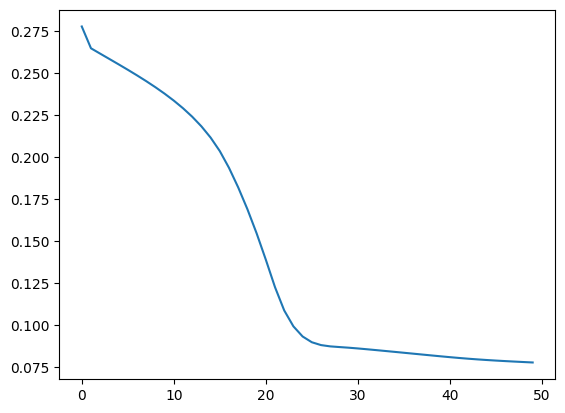

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from gnn import Gap, GraphConv, GNN
layers = [
    GraphConv(6, 3),
    GraphConv(3, 2),
    Gap(2, 1)
]

mse_l = [] 
gnn = GNN(layers)

num_epochs = 50
for epoch in range(num_epochs):
    ms = 0.0
    for i in range(len(train)):
        x, adj, y_true = train[i]
        y_pred = gnn.forward(x, adj)
        ms += (y_pred - y_true)**2
        dh = 2.0 * (y_pred - y_true)
        gnn.backward(dh)
        gnn.update_params(lr = 0.001)
    mse_val_train = ms / len(train)
    mse_l.append(mse_val_train)


plt.plot(mse_l)


In [18]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mse_val = mean_squared_error(y_true, y_pred)
    mae_val = mean_absolute_error(y_true, y_pred)
    r2_val = r2_score(y_true, y_pred)
    return mse_val, mae_val, r2_val

all_y_true = []
all_y_pred = []

for i in range(len(test)):
    x_test, adj_test, y_test = test[i]
    pred_test = gnn.forward(x_test, adj_test)
    
    all_y_true.append(y_test)
    all_y_pred.append(pred_test)


test_mse, test_mae, test_r2 = compute_metrics(all_y_true, all_y_pred)

print(f"MSE = {test_mse:.4f}")
print(f"MAE = {test_mae:.4f}")
print(f"R^2 = {test_r2:.4f}")


MSE = 0.0148
MAE = 0.0810
R^2 = 0.9115
